In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from eth_utils import humanize_hash, to_bytes
from web3 import Web3, HTTPProvider
from clr import *

import eth_chicago_QF_contract_abi

In [2]:
simulation = True
 
if simulation: # randomly generate projects, backers, and contribution amounts for simulation and testing
    n_backers = 40
    n_contribs = int(n_backers * 2.5)

    contr_distr = [1, 2, 4, 8, 16] # exponential distribution
    big_contr_distr = [i * 10**18 for i in contr_distr]

    project_ids = ['pizza', 'bonding_curve', 'tcr', 'pool_together', 'unisocks_fork'] + \
                    ['pizza']*3 + ['tcr']*2 + ['unisocks_fork']*5 # different project weightings
    backer_ids = ['0x' + str(i) for i in range(10000000, 10000000 + n_backers)]

    # create clr() input arrays
    projects = random.choices(project_ids, k = n_contribs)
    backers = random.choices(backer_ids, k = n_contribs)
    contribution_amounts = random.choices(big_contr_distr, k = n_contribs)
    
else: # read contribution data from the smart contract
    network = 'rinkeby' # set manually
    
    # get project id from .env
    import os
    from dotenv import load_dotenv
    load_dotenv()
    infura_project_id = os.getenv("INFURA_PROJECT_ID")
    
    infura_url = 'https://' + network + '.infura.io/v3/' + infura_project_id
    w3 = Web3(Web3.HTTPProvider(infura_url))

    eth_chicago_QF_contract_address = Web3.toChecksumAddress('0x834da8ad37f5bfc96f16209f74424ad9093a5aee')
    eth_chicago_QF_contract = w3.eth.contract(address = eth_chicago_QF_contract_address, 
                                              abi = eth_chicago_QF_contract_abi.abi)
    
#     project_names = ['paul'] # add these manually
    project_count = eth_chicago_QF_contract.functions.getProjectCount().call()
    project_names = []
    for index in range(project_count):
        project = eth_chicago_QF_contract.functions.getProjectNicknameAtIndex(index).call()
        project_names.append(project)

    projects = []
    backers = []
    contribution_amounts = []

    for project in project_names:
        contribution_count = eth_chicago_QF_contract.functions.getContributionCount(project).call()
        for index in range(contribution_count):
            projects.append(project)

            backer = eth_chicago_QF_contract.functions.getBackerAtIndex(project, index).call()
            backers.append(backer)

            amount = eth_chicago_QF_contract.functions.getAmountAtIndex(project, index).call()
            contribution_amounts.append(amount)

In [3]:
match_budget = 2000
grants, lr_matches, clr_matches = clr(projects, backers, contribution_amounts, match_budget)

In [4]:
# create tidy dataframe with all data
# columns: project, backer, contribution, backer_total, project_grant, LR_match, CLR_match
# rows: unique observations

df = pd.DataFrame.from_dict(grants) \
    .rename_axis('backer').reset_index() \
    .melt(id_vars = ['backer'], value_name = 'contribution_amount') \
    .rename(columns = {'variable':'project'}) \
    .dropna().reset_index(drop = True) \
    .assign(backer_short = lambda d: d['backer'].map(lambda backer: humanize_hash(to_bytes(hexstr = backer))),
            backer_total_contribution = lambda d: d.groupby('backer')['contribution_amount'].transform('sum'),
            project_total_contribution = lambda d: d.groupby('project')['contribution_amount'].transform('sum'),
            LR_match = lambda d: d['project'].map(lambda project: lr_matches[project]),
            CLR_match = lambda d: d['project'].map(lambda project: clr_matches[project])
           ) \
    .sort_values(by = 'backer_total_contribution', ascending = False)

df['project_total_grant'] = df.project_total_contribution + df.CLR_match
df['contribution_match'] = (df.contribution_amount / df.project_total_contribution) * df.CLR_match
df['matching_ratio'] = df.contribution_match / df.contribution_amount

In [5]:
# tidy dataframe at the recipient level
by_recip = df.groupby('project').max().drop(['backer',
                                                   'backer_short', 
                                                   'backer_total_contribution',
                                                   'contribution_amount',
                                                   'contribution_match'], axis = 1)
by_recip['contribution_count'] = df.groupby('project')['contribution_amount'].count()
by_recip['mean_contribution'] = df.groupby('project')['contribution_amount'].mean()
by_recip = by_recip.sort_values(by = 'project_total_grant', ascending = False)

# dataframe with rounded values for presentation
rounded = by_recip.round(2).round({'contribution_count': 0})

In [6]:
# setup plotting
%matplotlib inline
sns.set(style = 'darkgrid', context = 'talk')

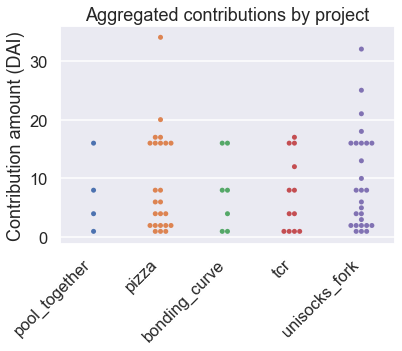

In [7]:
# plot contributions by recipient
ax = sns.swarmplot(x = 'project', y = 'contribution_amount', dodge = False, data = df)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel('Contribution amount (DAI)')
ax.set_title('Aggregated backer contributions by project') ;

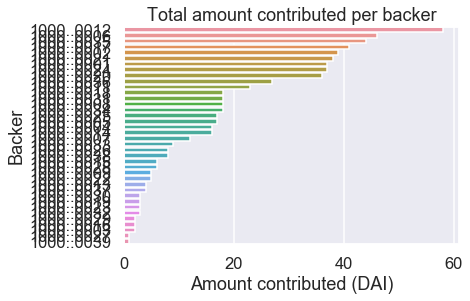

In [8]:
ax = sns.barplot(data = df, y = 'backer_short', x = 'backer_total_contribution', orient = 'h') 
ax.set_xlabel('Amount contributed (DAI)')
ax.set_ylabel('Backer')
ax.set_title('Total amount contributed per backer') ;

In [9]:
rounded

,project_total_contribution,LR_match,CLR_match,project_total_grant,matching_ratio,contribution_count,mean_contribution
project,,,,,,,
unisocks_fork,258.0,5658.63,1013.17,1271.17,3.93,27,9.56
pizza,221.0,4247.94,760.59,981.59,3.44,24,9.21
tcr,89.0,855.22,153.13,242.13,1.72,12,7.42
bonding_curve,54.0,311.76,55.82,109.82,1.03,7,7.71
pool_together,29.0,96.60,17.30,46.30,0.60,4,7.25


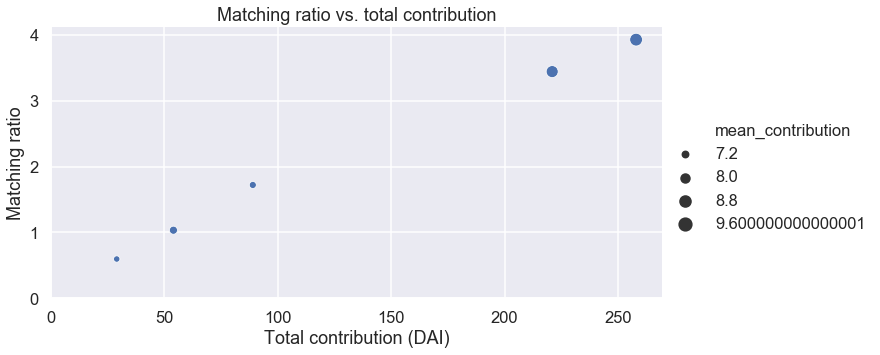

In [10]:
# plot clr matches by project total contribution by mean contribution
ax = sns.relplot(data = by_recip, x = 'project_total_contribution', y = 'matching_ratio', 
                size = 'mean_contribution', height = 5, aspect = 2)
ax.set(xlabel = 'Total contribution (DAI)', 
       ylabel = 'Matching ratio',
       title = 'Matching ratio vs. total contribution',
       xlim = 0,
       ylim = 0) ;

In [11]:
# #plot grant sums by number of funders by recipient
# sns.relplot(x = 'contribution_count', y = 'CLR_match', size = 'project_total_contribution', data = by_recip,
#            height = 5, aspect = 2) ;

In [12]:
# #plot clr match by project total contribution by mean contribution
# sns.relplot(x = 'project_total_contribution', y = 'CLR_match', size = 'mean_contribution', data = by_recip,
#            height = 5, aspect = 2) ;

In [13]:
# #plot contribution amount against contribution match amount, colored by project
# sns.relplot(data = df, x = 'contribution_amount', y = 'contribution_match', hue = 'project',
#            height = 5, aspect = 2) ;

In [14]:
# marginal = pd.DataFrame(columns = ['project', 'marginal_contribution', 'marginal_match', 'old_clr', 'new_clr'])

# for project in set(project_ids):
#     max_contrib = 1024 # find better name for amount
    
#     old_match = clr_matches[project]
    
#     new_projects = projects + [project]
    
#     for i in range(0, max_contrib):
#         new_contrib = i
#         nc_bigunits = new_contrib * 10**18
        
#         new_backers = backers + ['0x10000099']        
#         new_contribs = contribution_amounts + [nc_bigunits]
        
#         new_grants, new_lr, new_clr = clr(new_projects, new_backers, new_contribs, match_budget)
#         new_match = new_clr[project]
#         marginal_match = new_match - old_match
        
#         to_add = pd.DataFrame([[project, new_contrib, marginal_match, old_match, new_clr[project]],], 
#                               columns=['project', 
#                                         'marginal_contribution',
#                                         'marginal_match',
#                                         'old_clr',
#                                         'new_clr'])
#         marginal = marginal.append(to_add, ignore_index = True)

        
    

In [15]:
# sns.relplot(data = marginal, x = 'marginal_contribution', y = 'marginal_match', hue = 'project', 
#             kind = 'line', height = 8, aspect = 1.5) ;

In [16]:
# sns.relplot(data = marginal, x = 'marginal_contribution', y = 'marginal_match', hue = 'project', 
#             kind = 'line', height = 8, aspect = 1.5)
# plt.xscale('log', basex=2) 
# plt.xlim(2**0) ;